In [1]:
import pandas as pd

### Load the under employee dataset

In [2]:
# read CSV file from the 'data' subdirectory using a relative path
df = pd.read_csv('../data/under_employee.csv')

# display the first 5 rows
df.head()

,YEAR,DISTRICT,AGE_CAT,GENDER,COUNT
0,2008,11,2,2,16707.167113
1,2008,11,1,1,6194.798675
2,2008,11,1,2,8587.482721
3,2008,12,2,2,19420.847473
4,2008,12,1,1,4889.870235


In [3]:
# display the last 5 rows
df.tail()

,YEAR,DISTRICT,AGE_CAT,GENDER,COUNT
795,2006,22,1,2,1322.450794
796,2006,33,3,1,732.963625
797,2006,82,3,1,299.046257
798,2006,23,3,1,208.907160
799,2006,82,3,2,286.113528


In [4]:
# check the shape of the DataFrame (rows, columns)
df.shape

(800, 5)

### Data Preprocessing

#### 1. Replcaing empty cells with NaN(Not a number)

In [5]:
import numpy as np
df.replace(' ', np.nan, inplace=True)
df.head()

,YEAR,DISTRICT,AGE_CAT,GENDER,COUNT
0,2008,11,2,2,16707.167113
1,2008,11,1,1,6194.798675
2,2008,11,1,2,8587.482721
3,2008,12,2,2,19420.847473
4,2008,12,1,1,4889.870235


#### 2. Drop columns with NaN values 

In [6]:
df = df.dropna(axis=1, how='all')

#### NOTE: Best way to handle missing data

**Eliminating and Imputing** are two different strategies for handling samples or features with missing values.

Eliminating simply we remove the corresponding features (columns) or samples (rows) from the dataset entirely that have a certain number of missing values. The disadvantages for this strategy, we will run the risk of losing valuable information that our classifier needs to discriminate between classes.

Imputing we handle missing data by applying different interpolation techniques to estimate the missing values. One of the most common interpolation techniques is mean imputation, where we simply replace the missing value by the mean value of the entire feature column. A convenient way to achieve this is by using the Imputer class from scikit-learn, but filling missing values with this way is also a prediction which ignore the relation between missing values and other features.

Visualizing the important characteristics of a dataset is an important and recommended first step to clarifying the correlation between features to guide us to use a regression or another simple model to predict the values of missing variables. We have tried imputation here because we cannot loose data records.

#### 2. Imputation of missing values

##### i. Univariate vs. Multivariate Imputation

One type of imputation algorithm is univariate, which imputes values in the i-th feature dimension using only non-missing values in that feature dimension (e.g. impute.SimpleImputer). By contrast, multivariate imputation algorithms use the entire set of available feature dimensions to estimate the missing values (e.g. impute.IterativeImputer). As we can see we have to try multivariate imputation because it is the most sophisticated approach is to use. (***IterativeImputer class***)

In [7]:
from sklearn.impute import SimpleImputer
imp=SimpleImputer(missing_values=np.NaN)
idf=pd.DataFrame(imp.fit_transform(df))
idf.columns=df.columns
idf.index=df.index

In [8]:
idf.head()

,YEAR,DISTRICT,AGE_CAT,GENDER,COUNT
0,2008.0,11.0,2.0,2.0,16707.167113
1,2008.0,11.0,1.0,1.0,6194.798675
2,2008.0,11.0,1.0,2.0,8587.482721
3,2008.0,12.0,2.0,2.0,19420.847473
4,2008.0,12.0,1.0,1.0,4889.870235


## Encoding categorical features

### Label Encoding
And to convert this kind of categorical text data into model-understandable numerical data, we use the Label Encoder class. So all we have to do, to label encode the first column, is import the LabelEncoder class from the sklearn library, fit and transform the first column of the data, and then replace the existing text data with the new encoded data. Let’s have a look at the code.
But depending on the data, label encoding introduces a new problem. For example, we have encoded a set of country names into numerical data. This is actually categorical data and there is no relation, of any kind, between the rows.
The problem here is, since there are different numbers in the same column, the model will misunderstand the data to be in some kind of order, 0 < 1 < 2. But this isn’t the case at all. To overcome this problem, we use One Hot Encoder.
### One Hot Encoder
What one hot encoding does is, it takes a column which has categorical data, which has been label encoded, and then splits the column into multiple columns. The numbers are replaced by 1s and 0s, depending on which column has what value.

### One-hot encoding vs Dummy variables
By default, the get_dummies() does not do dummy encoding, but one-hot encoding. To produce an actual dummy encoding from your data, use drop_first=True. But here we need on hot encoding so we do not use that.

In [9]:
ydf = idf[['YEAR']]
ddf = pd.get_dummies(idf.DISTRICT,prefix=['DISTRICT'])
acdf = pd.get_dummies(idf.AGE_CAT,prefix=['AGE_CAT'])
gdf = pd.get_dummies(idf.GENDER,prefix=['GENDER'])
cdf = idf[['COUNT']]
frames = [ydf,ddf,acdf,gdf,cdf]
# print(gdf)

In [10]:
edf = pd.concat(frames, axis=1, sort=False)

In [11]:
edf.head()

,YEAR,['DISTRICT']_11.0,['DISTRICT']_12.0,['DISTRICT']_13.0,['DISTRICT']_21.0,['DISTRICT']_22.0,['DISTRICT']_23.0,['DISTRICT']_31.0,['DISTRICT']_32.0,['DISTRICT']_33.0,...,['DISTRICT']_81.0,['DISTRICT']_82.0,['DISTRICT']_91.0,['DISTRICT']_92.0,['AGE_CAT']_1.0,['AGE_CAT']_2.0,['AGE_CAT']_3.0,['GENDER']_1.0,['GENDER']_2.0,COUNT
0,2008.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,16707.167113
1,2008.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,6194.798675
2,2008.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,8587.482721
3,2008.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,19420.847473
4,2008.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,4889.870235


In [12]:
edf.tail()

,YEAR,['DISTRICT']_11.0,['DISTRICT']_12.0,['DISTRICT']_13.0,['DISTRICT']_21.0,['DISTRICT']_22.0,['DISTRICT']_23.0,['DISTRICT']_31.0,['DISTRICT']_32.0,['DISTRICT']_33.0,...,['DISTRICT']_81.0,['DISTRICT']_82.0,['DISTRICT']_91.0,['DISTRICT']_92.0,['AGE_CAT']_1.0,['AGE_CAT']_2.0,['AGE_CAT']_3.0,['GENDER']_1.0,['GENDER']_2.0,COUNT
795,2006.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1322.450794
796,2006.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,1,0,732.963625
797,2006.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,299.046257
798,2006.0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,208.907160
799,2006.0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,286.113528


In [14]:
edf.to_csv('../data/preproccessed/under_employee_p.csv', index=False)

### Feature engineering

In [13]:
# NOTE: If the models are more accuarte we do not need to do a feature engineering

In [14]:
X = edf.drop(['COUNT'], axis=1)
y = edf['COUNT']

### Original data visualization

In [15]:
import seaborn as sns

# visualize the relationship between the features and the response using scatterplots
sns.pairplot(idf, x_vars='YEAR', y_vars='COUNT', height=10, kind='reg')

# Feature selection

#### Plotting original data with regression line

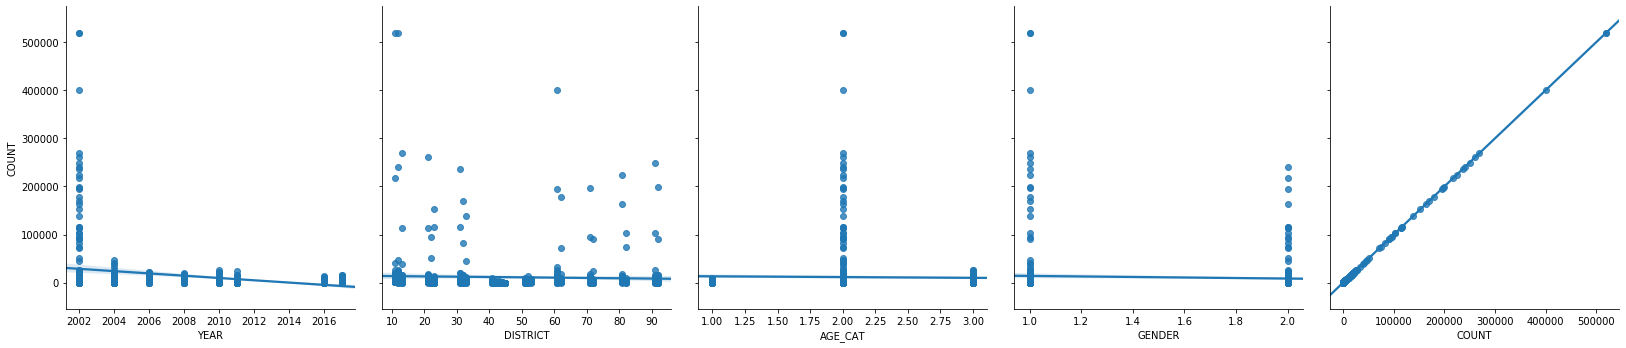

In [16]:
import seaborn as sns

# visualize the relationship between the features and the response using scatterplots
sns.pairplot(idf, x_vars=idf.columns, y_vars='COUNT', height=5, aspect=0.9, kind='reg')

Feature selection can be done in multiple ways but there are broadly 3 categories of it.
1. Filter Method
2. Wrapper Method
3. Embedded Method

(NOTE: 2 and 3 method are suited when lesser features (~20). Since there are more than 20 features we will use filter method.)

Reference link: https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

### 1. Filter Method
Plot the Pearson correlation heatmap and see the correlation of independent variables with the output variable. We will only select features which has correlation of above 0.5.

#### Pearson correlation heatmap

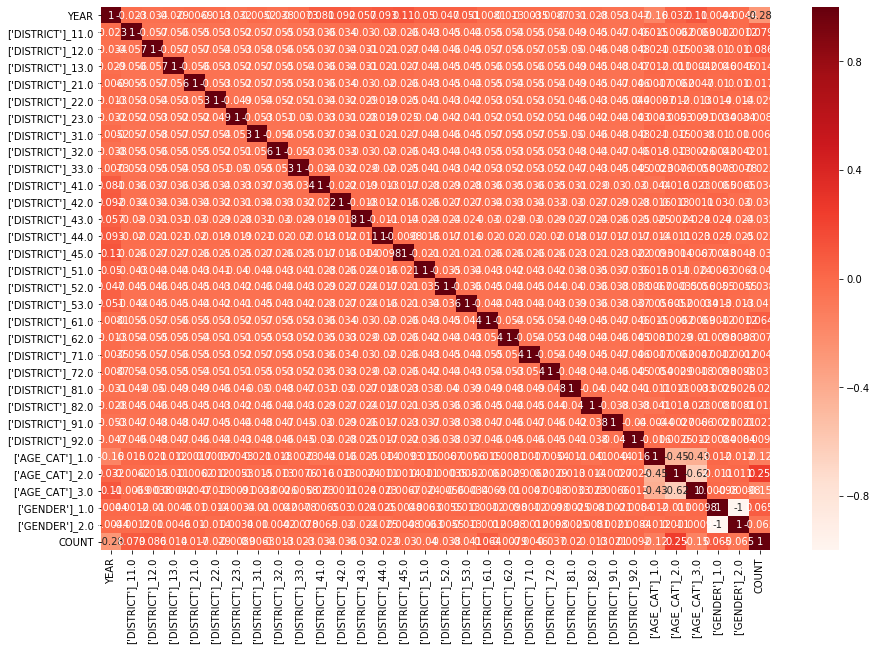

In [17]:
import matplotlib.pyplot as plt

#Using Pearson Correlation
plt.figure(figsize=(15,10))
cor = edf.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### Getting the selected features using correltion matrix

In [18]:
#Correlation with output variable
cor_target = abs(cor["COUNT"])#Selecting highly correlated features
selected_features_FM = cor_target[cor_target>=0.4]
selected_features_FM = list(selected_features_FM.keys())
selected_features_FM

['COUNT']

### 2. Wrapper Method
Feed the features to the selected Machine Learning algorithm and based on the model performance you add/remove the features. This is an iterative and computationally expensive process but it is more accurate than the filter method.

There are different wrapper methods such as Backward Elimination, Forward Selection, Bidirectional Elimination and RFE.

#### i. Backward Elimination
Check the performance of the model and then iteratively remove the worst performing features one by one till the overall performance of the model comes in acceptable range.

The performance metric used here to evaluate feature performance is pvalue. If the pvalue is above 0.05 then we remove the feature, else we keep it.

Here we are using OLS model which stands for “Ordinary Least Squares”. This model is used for performing linear regression.

In [19]:
import statsmodels.api as sm
#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['YEAR', "['DISTRICT']_11.0", "['DISTRICT']_12.0", "['DISTRICT']_13.0", "['DISTRICT']_21.0", "['DISTRICT']_22.0", "['DISTRICT']_23.0", "['DISTRICT']_31.0", "['DISTRICT']_32.0", "['DISTRICT']_33.0", "['DISTRICT']_41.0", "['DISTRICT']_42.0", "['DISTRICT']_43.0", "['DISTRICT']_44.0", "['DISTRICT']_45.0", "['DISTRICT']_51.0", "['DISTRICT']_52.0", "['DISTRICT']_53.0", "['DISTRICT']_61.0", "['DISTRICT']_62.0", "['DISTRICT']_71.0", "['DISTRICT']_72.0", "['DISTRICT']_81.0", "['DISTRICT']_82.0", "['DISTRICT']_91.0", "['DISTRICT']_92.0", "['AGE_CAT']_1.0", "['AGE_CAT']_2.0", "['AGE_CAT']_3.0", "['GENDER']_1.0", "['GENDER']_2.0"]


/home/asitha/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3. Embeded Method
Embedded methods are iterative in a sense that takes care of each iteration of the model training process and carefully extract those features which contribute the most to the training for a particular iteration. Regularization methods are the most commonly used embedded methods which penalize a feature given a coefficient threshold.

Here we will do feature selection using Lasso regularization. If the feature is irrelevant, lasso penalizes it’s coefficient and make it 0. Hence the features with coefficient = 0 are removed and the rest are taken.

Best alpha using built-in LassoCV: 53153.083623
Best score using built-in LassoCV: 0.009947
Lasso picked 1 variables and eliminated the other 30 variables


/home/asitha/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Text(0.5, 1.0, 'Feature importance using Lasso Model')

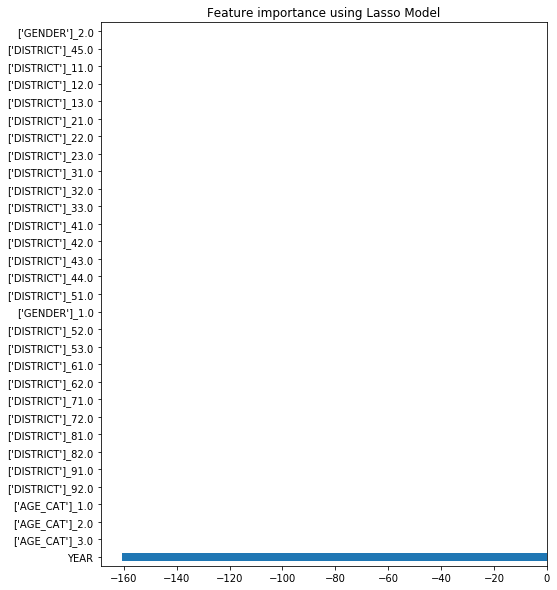

In [20]:
import matplotlib
from sklearn.linear_model import LassoCV

lassoReg = LassoCV()
lassoReg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % lassoReg.alpha_)
print("Best score using built-in LassoCV: %f" %lassoReg.score(X,y))
coef = pd.Series(lassoReg.coef_, index = X.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

### NOTE: Since there are not more than 20 feature we have used filter method. But filter method does not works with this dataset as we expected. So we have used backward eleimintaion. 

What are the features?
- **YEAR:**
- **GENDER:**
- **DISTRICT:** etc.

What is the response?
- **COUNT**

What else do we know?
- Because the response variable is continuous, this is a **regression** problem.

### Test the model with the subset of selected features and features that we need to check

In [21]:
# use the list to select a subset of the original DataFrame
# research_features = []
# X = edf[research_features]

#But we will feed the all the columns suggested by the feature selecting procudure.

# print the first 5 rows
X.head()

,YEAR,['DISTRICT']_11.0,['DISTRICT']_12.0,['DISTRICT']_13.0,['DISTRICT']_21.0,['DISTRICT']_22.0,['DISTRICT']_23.0,['DISTRICT']_31.0,['DISTRICT']_32.0,['DISTRICT']_33.0,...,['DISTRICT']_72.0,['DISTRICT']_81.0,['DISTRICT']_82.0,['DISTRICT']_91.0,['DISTRICT']_92.0,['AGE_CAT']_1.0,['AGE_CAT']_2.0,['AGE_CAT']_3.0,['GENDER']_1.0,['GENDER']_2.0
0,2008.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,2008.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,2008.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,2008.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,2008.0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [22]:
# check the type and shape of X
print(type(X))
print(X.shape)

<class 'pandas.core.frame.DataFrame'>
(800, 31)


In [23]:
# select a Series from the DataFrame
y = idf['COUNT']

# print the first 5 values
y.head()

0    16707.167113
1     6194.798675
2     8587.482721
3    19420.847473
4     4889.870235
Name: COUNT, dtype: float64

In [24]:
# check the type and shape of y
print(type(y))
print(y.shape)

<class 'pandas.core.series.Series'>
(800,)


## Splitting X and y into training and testing sets

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,test_size=0.1)

In [26]:
# Split is 90% for training and 10% for testing
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(720, 31)
(720,)
(80, 31)
(80,)


## Finding the best linear regression algorithm
#### Since this is extrapolating problem we can only use models which support extrapolate. Extrapoltaion means predicting out of sample test data

In [27]:
#import sklearn linear models
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV,\
Lasso, ElasticNet, \
Lars, OrthogonalMatchingPursuit, BayesianRidge, ARDRegression, \
SGDRegressor, PassiveAggressiveRegressor, \
RANSACRegressor, HuberRegressor, LassoLars, LassoLarsCV, ElasticNetCV

from sklearn.ensemble import AdaBoostRegressor
from sklearn.cross_decomposition import PLSRegression
models = {'LinearRegression': LinearRegression(),
          'Ridge': Ridge(),
          'RidgeCV': RidgeCV(),
          'SGDRegressor': SGDRegressor(),
          'RANSACRegressor': RANSACRegressor(),
          'Lasso': Lasso(),
          'ElasticNet': ElasticNet(),
          'ElasticNetCV': ElasticNetCV(),
          'Lars': Lars(),
          'OrthogonalMatchingPursuit': OrthogonalMatchingPursuit(),
          'BayesianRidge': BayesianRidge(),
          'PassiveAggressiveRegressor': PassiveAggressiveRegressor(),
          'HuberRegressor': HuberRegressor(),
          'LassoLars': LassoLars(),
          'LassoLarsCV': LassoLarsCV(),
          'ARDRegression': ARDRegression(),
         }

## Model evaluation metrics for regression

Evaluation metrics for classification problems, such as **accuracy**, are not useful for regression problems. Instead, we need evaluation metrics designed for comparing continuous values.

Let's create some example numeric predictions, and calculate **three common evaluation metrics** for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.

**R^2 (coefficient of determination) regression score function** Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

**Explained variance regression score function** Best possible score is 1.0, lower values are worse.

In [28]:
#Import non-sklearn packages
import numpy as np
import time
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import cross_val_score

warnings.filterwarnings("ignore")

print_coef = False

for key, model in models.items():
    begin = time.time()
    model.fit(X_train,y_train)
    print(key + ' Train time: ' + str((time.time() - begin)/60) + " minutes")
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test,preds)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test,preds)
    m_score = model.score(X_test,y_test)
    ex_va_score = explained_variance_score(y_test, preds)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print(key + ' MSE: ' + str(mse))
    print(key + ' R2 ' + str(r2))
    print(key + ' MAE ' + str(mae))
    print(key + ' Explained Variance Score ' + str(ex_va_score))
    print("Model score: %0.2f%s"%(m_score*100,'%'))
    print("Cross validation accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    if print_coef:
        print('Coefficients:')
        print(model.coef_)
    print('')

LinearRegression Train time: 6.868839263916016e-05 minutes
LinearRegression MSE: 669917367.8594961
LinearRegression R2 0.16540556722097333
LinearRegression MAE 16470.792787658593
LinearRegression Explained Variance Score 0.16603569183342481
Model score: 16.54%
Cross validation accuracy: 0.11 (+/- 0.08)

Ridge Train time: 2.8757254282633462e-05 minutes
Ridge MSE: 666697708.9839475
Ridge R2 0.169416672921317
Ridge MAE 16401.78257333694
Ridge Explained Variance Score 0.17009329369360715
Model score: 16.94%
Cross validation accuracy: 0.11 (+/- 0.08)

RidgeCV Train time: 4.3833255767822264e-05 minutes
RidgeCV MSE: 646906526.8036692
RidgeCV R2 0.19407286375654265
RidgeCV MAE 15911.752814291574
RidgeCV Explained Variance Score 0.19513841054872694
Model score: 19.41%
Cross validation accuracy: 0.13 (+/- 0.09)

SGDRegressor Train time: 4.252195358276367e-05 minutes
SGDRegressor MSE: 2.4670015828201173e+29
SGDRegressor R2 -3.073432464152125e+20
SGDRegressor MAE 496687778857311.6
SGDRegressor Exp

#### NOTE: We cannot achieve more than 50% accuary using those model.
## Polynomial interpolation
This shows that you can do non-linear regression with a linear model, using a pipeline to add non-linear features.

In [29]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

for key, model in models.items():
    begin = time.time()
    model = Pipeline([('scale', StandardScaler()),('poly', PolynomialFeatures()), (key, model)])
    model.fit(X_train,y_train)
    print('Poly-' + key + ' Train time: ' + str((time.time() - begin)/60) + " minutes")
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test,preds)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test,preds)
    m_score = model.score(X_test,y_test)
    ex_va_score = explained_variance_score(y_test, preds)
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print('Poly-' + key + ' MSE: ' + str(mse))
    print('Poly-' + key + ' R2 ' + str(r2))
    print('Poly-' + key + ' MAE ' + str(mae))
    print('Poly-' + key + ' Explained Variance Score ' + str(ex_va_score))
    print("Model score: %0.2f%s"%(m_score*100,'%'))
    print("Cross validation accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    if print_coef:
        print('Coefficients:')
        print(model.coef_)
    print('')

Poly-LinearRegression Train time: 0.0011108477910359701 minutes
Poly-LinearRegression MSE: 619875050.3889173
Poly-LinearRegression R2 0.22774913609686664
Poly-LinearRegression MAE 17638.001709519296
Poly-LinearRegression Explained Variance Score 0.22795419756778346
Model score: 22.77%
Cross validation accuracy: -69232729225148728606720.00 (+/- 198778269262571110400000.00)

Poly-Ridge Train time: 0.00034111738204956055 minutes
Poly-Ridge MSE: 600413043.5887035
Poly-Ridge R2 0.25199523465386464
Poly-Ridge MAE 17280.5738998314
Poly-Ridge Explained Variance Score 0.25295413749690976
Model score: 25.20%
Cross validation accuracy: 0.20 (+/- 0.22)

Poly-RidgeCV Train time: 0.001212310791015625 minutes
Poly-RidgeCV MSE: 593287305.1522137
Poly-RidgeCV R2 0.2608726006005575
Poly-RidgeCV MAE 17043.16235923767
Poly-RidgeCV Explained Variance Score 0.26184453583411693
Model score: 26.09%
Cross validation accuracy: 0.21 (+/- 0.21)

Poly-SGDRegressor Train time: 0.00027762651443481446 minutes
Poly-SG

### NOTE: We can see that accuary increased and MAE and R2 redused

In [30]:
begin = time.time()
best_model = Pipeline([('scale', StandardScaler()),('poly', PolynomialFeatures()), ('ll', LassoLarsCV())])
best_model_name = 'Poly-LassoLarsCV'
best_model.fit(X_train,y_train)
print(best_model_name + ' Train time: ' + str((time.time() - begin)/60) + " minutes")
preds = best_model.predict(X_test)
mse = mean_squared_error(y_test,preds)
r2 = r2_score(y_test,preds)
m_score = best_model.score(X_test,y_test)
ex_va_score = explained_variance_score(y_test, preds)
scores = cross_val_score(best_model, X_train, y_train, cv=5)
print(best_model_name + ' MSE: ' + str(mse))
print(best_model_name + ' R2 ' + str(r2))
print(best_model_name + ' MAE ' + str(mae))
print(best_model_name + ' Explained Variance Score ' + str(ex_va_score))
print("Model score: %0.2f%s"%(m_score*100,'%'))
print("Cross validation accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Poly-LassoLarsCV Train time: 0.003453218936920166 minutes
Poly-LassoLarsCV MSE: 413193147.2132306
Poly-LassoLarsCV R2 0.4852369607486676
Poly-LassoLarsCV MAE 14703.426110766028
Poly-LassoLarsCV Explained Variance Score 0.48524478227761403
Model score: 48.52%
Cross validation accuracy: 0.28 (+/- 0.17)


## Hyperparameter Tuning
hyperparameter tuning is choosing a set of optimal hyperparameters for a learning algorithm. A hyperparameter is a parameter whose value is set before the learning process begins. Some examples of hyperparameters include penalty in logistic regression and loss in stochastic gradient descent.

### Tuning Strategies
1. Grid Search

Grid search is a traditional way to perform hyperparameter optimization. It works by searching exhaustively through a specified subset of hyperparameters. The benefit of grid search is that it is guaranteed to find the optimal combination of parameters supplied. The drawback is that it can be very time consuming and computationally expensive.

We can combat this with random search.
2. Random Search

Random search differs from grid search mainly in that it searches the specified subset of hyperparameters randomly instead of exhaustively. The major benefit being decreased processing time. There is a tradeoff to decreased processing time, however. We aren’t guaranteed to find the optimal combination of hyperparameters.

### Randomized Grid Search

In [31]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

ard = LassoLarsCV()
print("LassoLarsCV: ",ard.get_params())

parametersGrid = {"max_iter": [i for i in range(1,10000)],
                  "max_n_alphas": [i for i in range(1,10000)],
                  "eps": [i for i in np.arange(1e-20,1,0.1)],
                  "cv": [i for i in range(5,100)]
                 }

# grid = GridSearchCV(ard, parametersGrid, scoring='r2', cv=10)
grid = RandomizedSearchCV(ard, parametersGrid, random_state=0)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

LassoLarsCV:  {'copy_X': True, 'cv': 'warn', 'eps': 2.220446049250313e-16, 'fit_intercept': True, 'max_iter': 500, 'max_n_alphas': 1000, 'n_jobs': None, 'normalize': True, 'positive': False, 'precompute': 'auto', 'verbose': False}
Best Score:  0.12477731774277386
Best Params:  {'max_n_alphas': 5050, 'max_iter': 4116, 'eps': 0.30000000000000004, 'cv': 46}


In [32]:
begin = time.time()
best_model = Pipeline([('scale', StandardScaler()),\
                       ('poly', PolynomialFeatures()), \
                       ('ll', LassoLarsCV(cv=46,max_iter=4116, \
                                          max_n_alphas=5050,\
                                          eps=0.30000000000000004))])
best_model_name = 'Hyperparameter-tuned-Poly-LassoLarsCV'
best_model.fit(X_train,y_train)
print(best_model_name + ' Train time: ' + str((time.time() - begin)/60) + " minutes")
preds = best_model.predict(X_test)
mse = mean_squared_error(y_test,preds)
r2 = r2_score(y_test,preds)
m_score = best_model.score(X_test,y_test)
ex_va_score = explained_variance_score(y_test, preds)
scores = cross_val_score(best_model, X_train, y_train, cv=5)
print(best_model_name + ' MSE: ' + str(mse))
print(best_model_name + ' R2 ' + str(r2))
print(best_model_name + ' MAE ' + str(mae))
print(best_model_name + ' Explained Variance Score ' + str(ex_va_score))
print("Model score: %0.2f%s"%(m_score*100,'%'))
print("Cross validation accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Hyperparameter-tuned-Poly-LassoLarsCV Train time: 0.017585444450378417 minutes
Hyperparameter-tuned-Poly-LassoLarsCV MSE: 398864105.4813365
Hyperparameter-tuned-Poly-LassoLarsCV R2 0.5030883242604214
Hyperparameter-tuned-Poly-LassoLarsCV MAE 14703.426110766028
Hyperparameter-tuned-Poly-LassoLarsCV Explained Variance Score 0.503162882049699
Model score: 50.31%
Cross validation accuracy: 0.30 (+/- 0.16)


## Neural Network

In [33]:
from sklearn.neural_network import MLPRegressor

begin = time.time()
best_model = MLPRegressor()
best_model_name = 'MLPRegressor'
best_model.fit(X_train,y_train)
print(best_model_name + ' Train time: ' + str((time.time() - begin)/60) + " minutes")
preds = best_model.predict(X_test)
mse = mean_squared_error(y_test,preds)
r2 = r2_score(y_test,preds)
m_score = best_model.score(X_test,y_test)
ex_va_score = explained_variance_score(y_test, preds)
scores = cross_val_score(best_model, X_train, y_train, cv=5)
print(best_model_name + ' MSE: ' + str(mse))
print(best_model_name + ' R2 ' + str(r2))
print(best_model_name + ' MAE ' + str(mae))
print(best_model_name + ' Explained Variance Score ' + str(ex_va_score))
print("Model score: %0.2f%s"%(m_score*100,'%'))
print("Cross validation accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

MLPRegressor Train time: 0.007901223500569661 minutes
MLPRegressor MSE: 806896661.2631065
MLPRegressor R2 -0.005245562553341188
MLPRegressor MAE 14703.426110766028
MLPRegressor Explained Variance Score -0.000357630990853286
Model score: -0.52%
Cross validation accuracy: -0.00 (+/- 0.01)


### Hyperparameter testing in neural network

In [34]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

ard = MLPRegressor()
print("MLPRegressor: ",ard.get_params())

parametersGrid = {"hidden_layer_sizes": [i for i in range(1,1000)],
                  "activation": ['identity', 'logistic', 'tanh', 'relu'],
                  "solver": ['lbfgs', 'sgd', 'adam'],
                  "learning_rate": ['constant', 'invscaling', 'adaptive'],
                  "power_t": [i for i in np.arange(1e-2,10,0.1)],
                  "max_iter": [i for i in range(1,1000)],
                  "tol": [i for i in np.arange(1e-6,10,0.1)],
                  "momentum": [i for i in np.arange(0,1,0.1)],
                  "validation_fraction": [i for i in np.arange(0,1,0.1)],
                  "beta_1": [i for i in np.arange(0,0.9,0.1)],
                  "beta_2": [i for i in np.arange(0,0.9,0.1)],
                  "epsilon": [i for i in np.arange(1e-8,1,0.1)],
                  "n_iter_no_change": [i for i in range(5,100)]
                 }

# grid = GridSearchCV(ard, parametersGrid, scoring='r2', cv=10)
grid = RandomizedSearchCV(ard, parametersGrid, random_state=0)
grid_result = grid.fit(X_train, y_train)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

MLPRegressor:  {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
Best Score:  0.03175923050023562
Best Params:  {'validation_fraction': 0.2, 'tol': 1.800001, 'solver': 'lbfgs', 'power_t': 9.31, 'n_iter_no_change': 57, 'momentum': 0.7000000000000001, 'max_iter': 983, 'learning_rate': 'adaptive', 'hidden_layer_sizes': 660, 'epsilon': 0.40000001, 'beta_2': 0.8, 'beta_1': 0.6000000000000001, 'activation': 'identity'}


In [35]:
from sklearn.neural_network import MLPRegressor

begin = time.time()
best_model = Pipeline([('scale', StandardScaler()),\
                       ('poly', PolynomialFeatures()), \
                       ('ll', MLPRegressor(validation_fraction= 0.2,\
                                           tol= 5.500001, \
                                           solver= 'lbfgs', \
                                           power_t= 5.41, \
                                           n_iter_no_change= 60, \
                                           momentum= 0.6000000000000001, \
                                           max_iter= 275, \
                                           learning_rate= 'constant', \
                                           hidden_layer_sizes= 899, \
                                           epsilon= 0.40000001, \
                                           beta_2= 0.0, \
                                           beta_1= 0.7000000000000001, \
                                           activation= 'relu'))])
best_model_name = 'MLPRegressor'
best_model.fit(X_train,y_train)
print(best_model_name + ' Train time: ' + str((time.time() - begin)/60) + " minutes")
preds = best_model.predict(X_test)
mse = mean_squared_error(y_test,preds)
r2 = r2_score(y_test,preds)
m_score = best_model.score(X_test,y_test)
ex_va_score = explained_variance_score(y_test, preds)
scores = cross_val_score(best_model, X_train, y_train, cv=5)
print(best_model_name + ' MSE: ' + str(mse))
print(best_model_name + ' R2 ' + str(r2))
print(best_model_name + ' MAE ' + str(mae))
print(best_model_name + ' Explained Variance Score ' + str(ex_va_score))
print("Model score: %0.2f%s"%(m_score*100,'%'))
print("Cross validation accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

MLPRegressor Train time: 0.41508185068766273 minutes
MLPRegressor MSE: 400839154.6408696
MLPRegressor R2 0.5006277744790685
MLPRegressor MAE 14703.426110766028
MLPRegressor Explained Variance Score 0.5130430606575891
Model score: 50.06%
Cross validation accuracy: 0.48 (+/- 0.43)


## Conclusion
After the all strategies we can conclude that MLPRegressor model (with hyperparameter tuning) works better with polynomial features.

In [36]:
import pickle
# save the model to disk
filename = '../models/under_employee.sav'
pickle.dump(best_model, open(filename, 'wb'))